In [52]:
# Import packages 
import numpy as np
from matplotlib import pyplot as plt
import skimage
import math

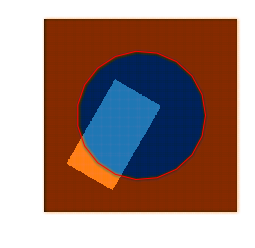

In [3]:
# Load data as binary image:
Square = skimage.color.rgb2gray(skimage.io.imread("sample.png")).astype(np.int);
h,w = Square.shape

plt.imshow(Square, cmap = 'gray');
plt.axis("off");

# Make the initial Snake as a circle:
def InitSnake(center, radius, npoints):
    t = np.linspace(0,2*np.pi, npoints)
    Snake = np.asarray([center[0] + radius*np.cos(t), center[1] + radius*np.sin(t)])
    return Snake, center, radius

Snake, c, r = InitSnake((h/2,w/2), h/3, 20)
plt.plot(Snake[0,:], Snake[1,:], color = 'r', linewidth = 1)

def FindROI(im,curve):
    #use skimage to find mask from curve
    ROI=[]
    notROI=[]
    i,j= np.indices(im.shape)
    indices=np.asarray([i.flatten(),j.flatten()])
    truth=skimage.measure.points_in_poly(indices.T,Snake.T)
    for x in range(len(truth)):
        if truth[x] == True:
            ROI.append([indices[0][x],indices[1][x]])
        else:
            notROI.append([indices[0][x],indices[1][x]])
    return np.transpose(ROI),np.transpose(notROI)

ROI,notROI=FindROI(Square,Snake)

plt.scatter(ROI[0,:],ROI[1,:],alpha=0.01)
plt.scatter(notROI[0,:],notROI[1,:],alpha=0.01)
    


-26.08605823335381 59.47022261534087


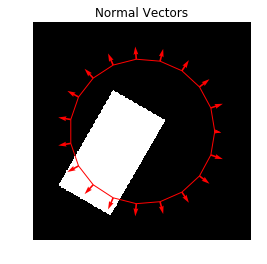

In [55]:
# Compute bilinear interpolaten of the Snake curve:
def BilinearInterpol(im, curve):
    # Associated intensity after interpolation:
    IntensityOut = np.zeros((1,curve.shape[1]))
    
    for i in range(curve.shape[1]):
        # Declare pixel locations and 'distance' from pixels 
        x  = curve[0][i]
        y  = curve[1][i]
        x0 = np.floor(x)
        x1 = np.ceil(x)
        y0 = np.floor(y)
        y1 = np.ceil(y)
        dx = x - x0
        dy = y - y0
        Nhood = np.asarray([[x0, x0, x1, x1], [y0, y1, y0, y1]]).astype(np.int)
        dist = np.asarray([ (1 - dx)*(1 - dy), dx*(1 - dy), (1 - dx)*dy, dx*dy ])
        IntensityOut[0,i] = im[Nhood[0], Nhood[1]].dot(dist)
    return IntensityOut

Intensities = BilinearInterpol(Square, Snake)

# Using these Regions Of Interest, Compute the magnitude (scalar value) of the Snake displacement:
# Fext =(m_in − m_out)*(2*I − m_in − m_out)*N
def ComputeDisplacement(im, curve):
    # Find mean intensities as before with ROI:
    ROI, notROI = FindROI(im, curve)
    m_in  = np.mean(im[ROI])
    m_out = np.mean(im[notROI])
    I = BilinearInterpol(im, curve)
    Fext = (m_in - m_out)*(2*I - m_in - m_out)
    return Fext

Fmagn = ComputeDisplacement(Square, Snake)

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

# Find normal vectors of the Snake curve:
def NormalVectors(curve):
    NormVecs = np.zeros((2, curve.shape[1]))
    TangVecs = np.zeros((2, curve.shape[1]))
    for i in range(curve.shape[1]-1):
        TangVecs[:,i] = np.asarray([curve[0][i+1] - curve[0][i-1], curve[1][i+1] - curve[1][i-1]])
    TangVecs[:,-1] = TangVecs[:,0]
    
                     
    NormVecs[0,:]=TangVecs[1,:]
    NormVecs[1,:]=-TangVecs[0,:]
    return NormVecs



NormVecs = NormalVectors(Snake)
#NormVecsx = np.asarray(np.gradient(Snake))
#NormVecsy = np.asarray(np.gradient(Snake[1,:]))
#NormVecs  = np.asarray([NormVecsx, NormVecsy])

#print(Snake[0,5:8],Snake[1,5:8])
print(NormVecs[0,6],NormVecs[1,6])

plt.imshow(Square, cmap = 'gray');
plt.axis("off");
plt.plot(Snake[0,:], Snake[1,:], color = 'r', linewidth = 1)
plt.quiver(Snake[0,:], Snake[1,:],NormVecs[0,:], NormVecs[1,:], color = 'r',angles='xy')

plt.title('Normal Vectors');

In [ ]:
def updateEdges(curve,ROI,notROI,step):
    meanIn=np.mean(ROI)
    meanOut=np.mean(notROI)
    

90000


In [158]:
# Construct the transformation matrices:
# Kernel for minimum length
Lml = -2*np.identity(h, dtype = None).astype(np.int); 
for x in range(0,h):
    Lml[x-1,x] = 1
    Lml[x,x-1] = 1

# Kernel for minimum curvature
Lmc = -6*np.identity(h, dtype = None).astype(np.int)
for x in range(0,h):
    Lmc[x-1,x] = 4
    Lmc[x,x-1] = 4
    Lmc[x-2,x] = -1
    Lmc[x,x-2] = -1